## Week 5 workshop

In this week, we'll train a GPT-style model on text by Shakespeare and get the model to speak like Shakespeare.

The model we're using is a from-scratch implementation of a model similar to Llama 2, written by [Clément Labrugere.](https://github.com/clabrugere) His original code is on GitHub here: https://github.com/clabrugere/scratch-llm. A copy of this repository as of September 2025 is included here in the `scratch-llm` folder.

First we import the required dependencies:

In [1]:
import sys
from pathlib import Path
import torch
from torch.utils.data import DataLoader
import polars as pl
from plotnine import ggplot, aes, geom_line, labs, theme_minimal

sys.path.append("scratch-llm")
from model.llm import LLM
from model.tokenizer import Tokenizer, train_tokenizer

from helpers.dataset import NextTokenPredictionDataset
from helpers.trainer import train
from helpers.config import LLMConfig, TrainingConfig, get_device

Next the setup for the model and for model training.

In [2]:
llm_config = LLMConfig(
    vocab_size = 4096,
    seq_len = 128,
    dim_emb = 256,
    num_layers = 4,
    num_heads = 8,
    emb_dropout = 0.0,
    ffn_dim_hidden = 4 * 256,
    ffn_bias = False
)
train_config = TrainingConfig(
    retrain_tokenizer = False,
    device = get_device(),
    batch_size = 64,
    learning_rate = 3e-4,
    weight_decay = 1e-5,
    max_epochs = 3,
    log_frequency = 10
)

Before we can train the model, we need to train the tokenizer.

In [3]:
input_file = "data/tinyshakespeare.txt"
output_file = Path(input_file).with_suffix(".model")

if not output_file.exists() or train_config.retrain_tokenizer:
    train_tokenizer(input_file, llm_config.vocab_size)

tokenizer = Tokenizer(str(output_file))

A demonstration of the tokenizer in action.

In [4]:
sentence = "Before we proceed any further, hear me speak."
print(tokenizer.sp.EncodeAsPieces(sentence))

['▁Before', '▁we', '▁proceed', '▁any', '▁further', ',', '▁hear', '▁me', '▁speak', '.']


## Model setup and training

Generate the model instance using the configuration options previously chosen.

In [5]:
model = LLM(
    vocab_size = tokenizer.vocab_size,
    seq_len = llm_config.seq_len,
    dim_emb = llm_config.dim_emb,
    num_layers = llm_config.num_layers,
    attn_num_heads = llm_config.num_heads,
    emb_dropout = llm_config.emb_dropout,
    ffn_hidden_dim = llm_config.ffn_dim_hidden,
    ffn_bias = llm_config.ffn_bias
)

params_size = sum(p.nelement() * p.element_size() for p in model.parameters())
buffer_size = sum(p.nelement() * p.element_size() for p in model.buffers())
size = (params_size + buffer_size) / 1024**2

print(f"Total model parameters: {sum(p.numel() for p in model.parameters()):,d}")
print(f"Model size: {size:.3f}MB\n")
#print(model)

Total model parameters: 12,597,504
Model size: 48.243MB



Set up the training data and the corresponding data loader. When you look carefully at the training labels, you will notice they are exactly shifted one relative to the training inputs. That's because we're training next-token prediction.

In [6]:
# training data
ds_train = NextTokenPredictionDataset(input_file, llm_config.seq_len, tokenizer)

# data loader
dl_train = DataLoader(ds_train, batch_size = train_config.batch_size, shuffle = True)

# make pytorch print more numbers in the array instead of abbreviating with ...
torch.set_printoptions(edgeitems = 5)

# print inputs and labels for the first training iteration
for inputs, labels in dl_train:
    print(f"Tensor shapes\n  input: {inputs.shape}\n output: {labels.shape}\n")
    print(f"Inputs:\n{inputs}\n")
    print(f"Labels:\n{labels}\n")
    
    break

Tensor shapes
  input: torch.Size([64, 128])
 output: torch.Size([64, 128])

Inputs:
tensor([[4095, 1710,   10,  417,   63,  ...,    3,  190, 3404,  232,  201],
        [   9, 2540,   15,  801,    4,  ...,   99,   20,    3, 2002,  429],
        [   7,    3,    3,   12,  460,  ...,   19, 2133,    7,    3,    3],
        [  12,   81,  159,  469,    5,  ...,  259,  256,    4,   28,  373],
        [ 295,   61,    5,    3, 1954,  ...,   13,   19, 1197, 2226,   52],
        ...,
        [   4,  582,  429,    7,    3,  ...,  414,   16,  591,  521,    3],
        [   8,  342,    5,    3,   54,  ...,    4,    3,   50,  137,   87],
        [  14,   19,  334,   62,   28,  ...,    4,    3,  190,   57,    4],
        [   8,  254,    3,  629,   19,  ...,    7,    3,    3,  159,    5],
        [   3,  519,  860,   82,  391,  ...,  132,  133,  363,   51,    5]])

Labels:
tensor([[1710,   10,  417,   63,   30,  ...,  190, 3404,  232,  201,   13],
        [2540,   15,  801,    4,    3,  ...,   20,    3,

Next we train the model (if you set `train_llm = True`). This may take a couple of hours, depending on your computer.

In [7]:
train_llm = False

if train_llm:
    loss_history = train(
        model,
        dl_train,
        train_config.device,
        lr = train_config.learning_rate,
        max_epochs = train_config.max_epochs,
        weight_decay = train_config.weight_decay,
        log_every = train_config.log_frequency
    )
    # save the model
    torch.save(model.state_dict(), "data/tinyshakespeare_llm.pt")

    # save the history from the training run
    df = pl.DataFrame({
        'index': range(len(loss_history['train_loss'])),
        'train_loss': loss_history['train_loss']
    })
    df.write_csv('data/loss_history.csv')

Plot the history of the training loss.

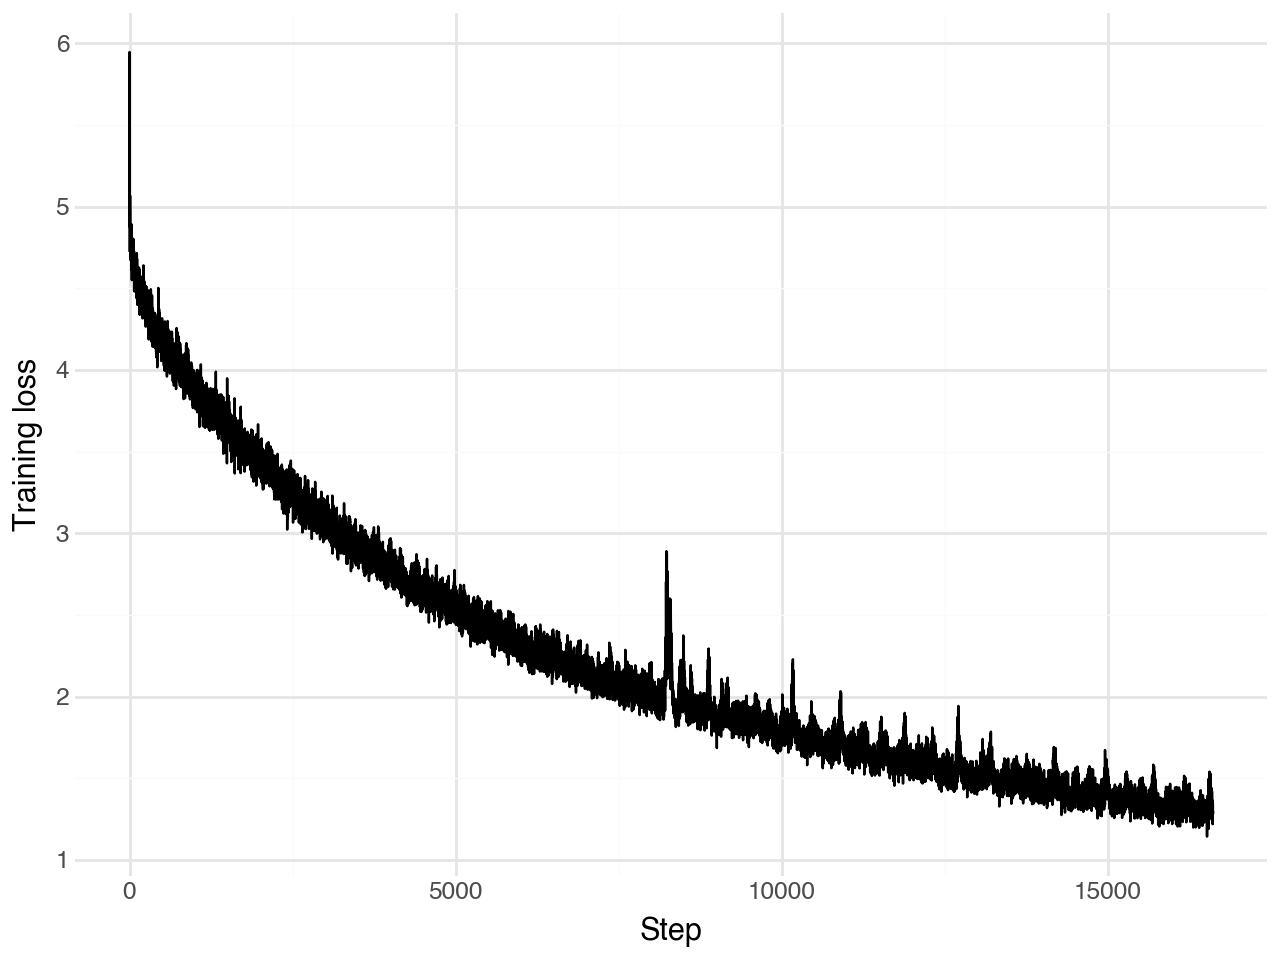

In [8]:
# Load the DataFrame back from the CSV file
loss_history = pl.read_csv('data/loss_history.csv')

plot = (
    ggplot(loss_history, aes(x = 'index', y = 'train_loss')) +
        geom_line() +
        labs(
            x = 'Step',
            y = 'Training loss'
        ) +
        theme_minimal()
    )

plot

## Using the model

To use the model, we don't have to retrain. We can just load the model that we saved previously and start exploring.

In [9]:
# move the model to the appropriate GPU device
model.to(train_config.device)

# load the saved model weights
model.load_state_dict(torch.load(
    "data/tinyshakespeare_llm.pt",
    weights_only = True,
    map_location = train_config.device
))

# put the model into evaluation mode
model.eval()

LLM(
  (token_embedding): Embedding(4096, 256)
  (emb_dropout): Dropout(p=0.0, inplace=False)
  (transformer): Sequential(
    (0): TransformerBlock(
      (norm_attn): RMSNorm()
      (multihead_attn): MultiHeadAttention(
        (positional_encoding): RotaryPositionalEncoding()
        (proj_qkv): Linear(in_features=256, out_features=768, bias=False)
        (proj_out): Linear(in_features=256, out_features=256, bias=False)
      )
      (norm_ffn): RMSNorm()
      (feed_forward): FeedForward(
        (0): Linear(in_features=256, out_features=1024, bias=False)
        (1): SwiGLU(
          (linear): Linear(in_features=1024, out_features=2048, bias=True)
        )
        (2): Linear(in_features=1024, out_features=256, bias=False)
      )
    )
    (1): TransformerBlock(
      (norm_attn): RMSNorm()
      (multihead_attn): MultiHeadAttention(
        (positional_encoding): RotaryPositionalEncoding()
        (proj_qkv): Linear(in_features=256, out_features=768, bias=False)
        (pro

Let's start with an empty prompt to generate random text.

In [10]:
prompt = torch.full((1, llm_config.seq_len), tokenizer.eos_id, dtype = torch.int32)
print(f"The prompt input:\n{prompt}\n")
prompt = prompt.to(train_config.device)
out = model.generate(prompt, max_seq_len = 64, top_p = 1)
print(f"The output in token form:\n{out}")
print(f"The output decoded:\n{tokenizer.decode(out.tolist())}")

The prompt input:
tensor([[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
         3, 3, 3, 3, 3, 3, 3, 3]], dtype=torch.int32)

The output in token form:
tensor([   3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,    3,
           3,   

We can also generate from a starting prompt.

In [11]:
prompt = tokenizer.encode(
    "KING HENRY VI:",
    beg_of_string = True,
    pad_seq = True,
    seq_len = llm_config.seq_len
)

# convert prompt into tensor the model can work with
inputs = torch.tensor(prompt, dtype=torch.int32).unsqueeze(0).to(train_config.device)

# print the input tensor
print(f"The prompt input:\n{inputs.cpu()}\n")

# generate output
out = model.generate(inputs, max_seq_len=64, top_p=1)
print(f"The output in token form:\n{out}")
print(f"The output decoded:\n{tokenizer.decode(out.tolist())}")

The prompt input:
tensor([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   2,  12,  81,  12, 228, 199,
         132,   5]], dtype=torch.int32)

The output in token form:
tensor([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0, 

## Exploring model parameters

Structure of the model parameters:

- **0** :: weight matrix for **token embeddings**

<!-- -->

- **1** :: **RMSNorm** parameter vector
- **2** :: Q, K, V matrices (concatenated) for **MultiHeadAttention**
- **3** :: weight matrix for projout part of **MultiHeadAttention**
- **4** :: **RMSNorm** parameter vector
- **5** :: initial weight matrix for **FeedForward (SwiGLU)** part
- **6** :: **SwiGLU** weight matrices (concatened)
- **7** :: **SwiGLU** bias vector
- **8** :: final weight matrix for **FeedForward (SwiGLU)** part

<!-- -->

-  **9-16** :: as 1-8 but for second TransformerBlock
- **17-24** ::        "       third         "
- **25-32** ::        "       fourth        "

<!-- -->

- **33** :: **RMSNorm** parameter vector
- **34** :: final **projection_head** bias vector

**NOTE**: there is no weight matrix for the final projection head b/c it is "weight-tied" to the token embeddings weight matrix (0 above)

In [12]:
parList = list(model.parameters())
len(parList) ## 35
parShapes = [list(el.shape) for el in parList]
parShapes

[[4096, 256],
 [256],
 [768, 256],
 [256, 256],
 [256],
 [1024, 256],
 [2048, 1024],
 [2048],
 [256, 1024],
 [256],
 [768, 256],
 [256, 256],
 [256],
 [1024, 256],
 [2048, 1024],
 [2048],
 [256, 1024],
 [256],
 [768, 256],
 [256, 256],
 [256],
 [1024, 256],
 [2048, 1024],
 [2048],
 [256, 1024],
 [256],
 [768, 256],
 [256, 256],
 [256],
 [1024, 256],
 [2048, 1024],
 [2048],
 [256, 1024],
 [256],
 [4096]]

Extracting token embeddings.

In [13]:
# extract list of all tokens
tokens = [tokenizer.sp.id_to_piece(i) for i in range(llm_config.vocab_size)]

print(tokenizer.sp.piece_to_id("▁perforce"))
print(tokenizer.sp.piece_to_id("▁basilisk"))

2554
4077


In [14]:
# Convert tensor to numpy array and create DataFrame
embedding_data = parList[0].cpu().detach().numpy()
print(embedding_data.shape)

# _basilisk is token 4077
print(embedding_data[4077, :])

# Create DataFrame with token column plus embedding dimensions
embeddings = pl.DataFrame({
    'token': tokens,
    **{f'dim_{i}': embedding_data[:, i] for i in range(embedding_data.shape[1])}
})

target_tokens = ["▁basilisk", "▁perforce", "▁castle"]
embeddings.filter(pl.col('token').is_in(target_tokens))

(4096, 256)
[-1.30053831e-03  2.93207932e-02 -2.78215017e-02  1.50135189e-01
 -3.44383530e-02 -4.02838252e-02 -1.98660716e-01 -8.90227184e-02
 -9.76802260e-02 -1.85345098e-01 -8.19444284e-03  6.25890791e-02
  9.72839538e-03  1.08322855e-02  8.84286314e-03  2.15906411e-01
 -2.17127442e-01 -4.67941463e-02  7.05773830e-02 -1.90465569e-01
 -5.05452901e-02 -1.14533506e-01 -5.09503819e-02 -2.69602481e-02
 -4.42347564e-02 -8.76817200e-03  1.02476589e-03 -4.14172793e-03
  1.38217762e-01  2.98200883e-02  1.17392510e-01  2.26524305e-02
  1.09132707e-01 -9.79859829e-02  1.27574638e-01  2.48097047e-01
 -1.50288269e-01  1.09515250e-01 -7.72665516e-02 -8.05330724e-02
  8.14706013e-02  4.84665558e-02  4.03876156e-02 -5.15549211e-03
 -7.10920766e-02 -7.27339908e-02  1.71256050e-01 -3.91995832e-02
 -1.06895827e-01  9.73379463e-02  1.15452312e-01 -3.57463228e-04
 -3.33718844e-02 -1.28576765e-02 -8.78523216e-02 -1.94899961e-01
  3.01881224e-01  1.68366626e-01 -2.21303795e-02 -9.70712081e-02
  9.20550898e

token,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,dim_10,dim_11,dim_12,dim_13,dim_14,dim_15,dim_16,dim_17,dim_18,dim_19,dim_20,dim_21,dim_22,dim_23,dim_24,dim_25,dim_26,dim_27,dim_28,dim_29,dim_30,dim_31,dim_32,dim_33,dim_34,dim_35,…,dim_219,dim_220,dim_221,dim_222,dim_223,dim_224,dim_225,dim_226,dim_227,dim_228,dim_229,dim_230,dim_231,dim_232,dim_233,dim_234,dim_235,dim_236,dim_237,dim_238,dim_239,dim_240,dim_241,dim_242,dim_243,dim_244,dim_245,dim_246,dim_247,dim_248,dim_249,dim_250,dim_251,dim_252,dim_253,dim_254,dim_255
str,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,…,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32,f32
"""▁castle""",-0.148215,0.197007,0.1249,0.021305,-0.121309,0.14587,0.259737,0.048309,0.286923,0.13779,0.011779,-0.030519,-0.173348,0.349873,-0.143959,0.357129,-0.150084,0.093061,0.325579,-0.10153,0.117874,0.233133,-0.230312,-0.094514,-0.126663,-0.139246,-0.064809,-0.149722,-0.163478,0.043311,-0.005281,-0.149828,0.08299,-0.09244,-0.03638,0.107713,…,-0.041608,0.124754,-0.0927,0.104195,0.105148,0.34459,0.014003,0.215244,0.154041,0.074032,-0.036821,-0.072911,-0.109559,-0.025216,0.016599,-0.135661,0.043836,-0.062106,-0.025945,0.192274,-0.340097,-0.194262,0.138081,0.184851,-0.016861,0.144102,0.20947,0.222077,-0.167625,0.3088,-0.346945,0.134195,0.197539,-0.249303,-0.180279,0.363111,-0.055227
"""▁perforce""",-0.153841,-0.274629,0.173357,0.049015,0.001886,0.17866,-0.014247,0.352402,0.029701,0.071924,-0.027173,0.056062,-0.053321,-0.08847,0.241883,0.044242,-0.08444,0.012871,-0.233677,0.073736,0.174775,0.263662,0.084643,0.045823,0.130946,0.123333,0.262025,0.040367,-0.129015,0.135108,-0.159329,-0.09433,0.094151,0.192522,-0.342727,0.069071,…,-0.302726,0.216747,-0.28534,0.068532,-0.051689,0.314963,0.105637,-0.206142,0.071576,-0.046063,0.011026,-0.164473,0.138242,-0.311956,-0.2274,-0.303799,-0.105977,-0.005794,0.110667,-0.116478,0.031044,-0.312319,-0.249584,0.018577,0.117485,-0.008807,-0.276737,0.032046,0.123242,-0.161981,-0.079343,-0.025822,0.029489,-0.266156,-0.239444,-0.154607,0.099395
"""▁basilisk""",-0.001301,0.029321,-0.027822,0.150135,-0.034438,-0.040284,-0.198661,-0.089023,-0.09768,-0.185345,-0.008194,0.062589,0.009728,0.010832,0.008843,0.215906,-0.217127,-0.046794,0.070577,-0.190466,-0.050545,-0.114534,-0.05095,-0.02696,-0.044235,-0.008768,0.001025,-0.004142,0.138218,0.02982,0.117393,0.022652,0.109133,-0.097986,0.127575,0.248097,…,-0.20958,-0.11634,-0.06938,0.106201,-0.317534,0.200011,0.056857,0.161848,0.162149,0.046978,-0.041519,0.007423,0.218404,0.058436,0.162892,-0.023739,-0.164718,0.31398,0.055259,0.175692,-0.058398,0.110983,-0.086261,0.180361,0.081902,0.020042,-0.105211,0.102362,-0.116001,0.261306,0.042691,-0.112341,-0.005003,-0.023965,-0.142263,0.153943,0.128183
